In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import harmonypy as hm
import anndata
import os
import scrublet

# new packages 
import muon as mu # multi-modal anndatas
import celltypist # automated label predictions
import scirpy # immune cell repertoire analysis

#sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set up the data directory
counts_dir = "/home/groups/singlecell/smorabito/shared/SERPENTINE/data/"


In [3]:
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/')
data_dir = 'data/'
fig_dir = 'figures/'


In [4]:
# loading the metadata table
meta_table = pd.read_csv(
    "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_metadata.txt", 
    sep='\t',
    encoding = 'utf-16'
)
meta_table['ID_CNAG'] = meta_table['ID_CNAG'].str.replace('-', '_', regex=True)


In [5]:
# remove samples that are not sequenced yet 
meta_table = meta_table[~meta_table.Subproject_CNAG.isin(['SERPENTINE_62_63', 'SERPENTINE_64_65', 'SERPENTINE_66_67'])]

In [6]:
# # only keep selected columns
# meta_table = meta_table[['Subproject_CNAG', 'ID_CNAG' 'Tissue', 'Sample', 'Timepoint']]
# meta_table = meta_table.drop_duplicates()

In [7]:
# loading the patient metadata table
patient_meta_table = pd.read_csv(
    "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_metadata_patient.txt",
    sep='\t',
    encoding = 'utf-16'
)
patient_meta_table.head()


Patient​      DOB​   Tumor Type​ Primary tumor​  \
0  Patient 01​  15APR71​          CRC​        Rectum​   
1  Patient 02​  25MAY70​          CRC​        Rectum​   
2  Patient 03​   9SEP61​          CRC​   Right colon​   
3  Patient 04​   7DEC68​  Endometrial​   Endometrial​   
4  Patient 05​   4SEP74​          CRC​       Sigmoid​   

                Histology​ Microsatellite status​  \
0          Adenocarcinoma​                   MSS​   
1          Adenocarcinoma​                   MSS​   
2          Adenocarcinoma​                   MSS​   
3  Endometrioid carcinoma​                   MSI​   
4          Adenocarcinoma​                   MSS​   

                Molecular profile​ N pre lines​  \
0                       KRAS G13D​           5​   
1                       KRAS G12S​           2​   
2                       KRAS G13D​           3​   
3  MLH1 hypermet, p53 wt, POLE wt​           1​   
4                       KRAS G12V​           3​   

                                 Previous therapies​  \
0  FOLFOX, FOLFOXIRI + Bev, FOLFIRI, FOLFIRI + Pa...   
1               FOLFOX + Bev, FOLFIRI + Aflibercept​   
2      FOLFOX + Bev, FOLFOXIRI + Bev, FOLFIRI + Bev​   
3                          Carboplatin + Paclitaxel​   
4                     FOLFOX, FOLFIRI + Bev, TAS102​   

                                Metastases location​    Cohort​  \
0  Liver, lung, adrenal, bone, peritoneum, lymph ...   2 (MSS)​   
1                          Liver, lung, lymph nodes​   2 (MSS)​   
2                              Liver, lung, adrenal​   2 (MSS)​   
3                                      Lung, pelvic​  1A (MSI)​   
4                                 Liver, peritoneum​   2 (MSS)​   

                   Treatment​ Biopsy pre-treat​ Biopsy pre-C2​ Biopsy​  \
0  Durvalumab + Tremelimumab​           1/10/23         2/7/23       ​   
1  Durvalumab + Tremelimumab​            2/1/23        3/20/23       ​   
2  Durvalumab + Tremelimumab​           3/20/23        4/17/23       ​   
3                Durvalumab ​            4/3/23         5/2/23       ​   
4  Durvalumab + Tremelimumab​           6/26/23              ​       ​   

  BiopsyEOT​        Best response​  
0          ​  Progression disease​  
1          ​  Progression disease​  
2          ​  Progression disease​  
3    5/23/23  Progression disease​  
4          ​    Screening failure​

In [8]:


# loop over each subproject name and load individual anndatas

adata_list = []

for cur_subproject in meta_table['Subproject_CNAG'].unique():
    print("")
    print(cur_subproject)
    
    # for this subproject, get the different reps that we sequenced (ie CD45+/- or total)
    if os.path.exists('{}{}/jobs/'.format(counts_dir, cur_subproject)):
        cur_reps = os.listdir('/home/groups/singlecell/smorabito/shared/SERPENTINE/data/{}/jobs/'.format(cur_subproject))
    else:
        cur_reps = os.listdir('/home/groups/singlecell/smorabito/shared/SERPENTINE/data/{}/jobs_human/'.format(cur_subproject))

    # loop over each replicate for this subproject, and load the gene expression counts matrices
    cur_adata_list = []
    for x in cur_reps:
        if os.path.exists('{}{}/jobs/'.format(counts_dir, cur_subproject)):
            cur_cellranger_dir = "{}{}/jobs/{}/{}/outs/per_sample_outs/{}/count/sample_filtered_feature_bc_matrix/".format(counts_dir, cur_subproject, x, x, x)
        else:
            cur_cellranger_dir = "{}{}/jobs_human/{}/{}/outs/per_sample_outs/{}/count/sample_filtered_feature_bc_matrix/".format(counts_dir, cur_subproject, x, x, x)
        try:
            cur_adata = sc.read_10x_mtx(cur_cellranger_dir)
        except:
            print('Issue loading {}, skipping for now.'.format(x))
            continue
        cur_adata.obs['Subproject_CNAG'] = cur_subproject 
        cur_adata.obs['Replicate'] = x

        # add patient label:
        tmp = x.split('_')
        if len(tmp) > 2:
            cur_patient = tmp[2]
            if len(cur_patient) == 1:
                cur_patient = '0' + cur_patient
        else:
            cur_patient = tmp[0]
        cur_patient = 'Patient ' + cur_patient
        print(cur_patient)
        cur_adata.obs['Patient'] = cur_patient
        cur_adata.obs['bc'] = [bc.split('-')[0] for bc in cur_adata.obs.index.to_list()]
        cur_adata_list.append(cur_adata)
        print(cur_adata.shape)

    adata_list = adata_list + cur_adata_list

        




SERPENTINE_04_05
Patient 01
(694, 36601)
Patient 01
(4682, 36601)

SERPENTINE_06_07
Patient 02
(8351, 36601)
Patient 02
(6858, 36601)

SERPENTINE_08_09
Patient 01
(4470, 36601)
Patient 01
(4011, 36601)

SERPENTINE_10_11
Patient 02
(6693, 36601)
Patient 03
(1110, 36601)
Patient 02
(5798, 36601)

SERPENTINE_12_13
Patient 04
(11125, 36601)
Patient 04
(11551, 36601)

SERPENTINE_14_15
Issue loading SPE_1_03_C02_A_FRESH, skipping for now.

SERPENTINE_16_17
Patient 04
(6516, 36601)
Patient 04
(5440, 36601)

SERPENTINE_18_19
Patient 03
(1451, 36601)
Patient 03
(8306, 36601)

SERPENTINE_20_21
Patient 05
(5481, 36601)
Patient 06
(1042, 36601)
Patient 06
(3623, 36601)

SERPENTINE_22_23
Patient 08
(15757, 36601)

SERPENTINE_24_25
Patient 09
(7434, 36601)

SERPENTINE_26_27
Patient 07
(3333, 36601)
Patient 07
(160, 36601)

SERPENTINE_28_29
Patient 10
(6935, 36601)
Patient 10
(15640, 36601)

SERPENTINE_30_31
Patient 08
(6484, 36601)
Patient 08
(6995, 36601)

SERPENTINE_32_33
Patient 09
(8119, 36601)

In [9]:
# concatenate into a single adata:
adata = adata_list[0].concatenate(adata_list[1:])

In [10]:
meta_table.Subproject_CNAG[~meta_table.ID_CNAG.isin(adata.obs.Replicate)]

0     SERPENTINE_04_05
1     SERPENTINE_04_05
11    SERPENTINE_14_15
49    SERPENTINE_54_55
50    SERPENTINE_56_57
51    SERPENTINE_56_57
52    SERPENTINE_58_59
53    SERPENTINE_58_59
54    SERPENTINE_60_61
55    SERPENTINE_60_61
Name: Subproject_CNAG, dtype: object

In [11]:
rep = adata.obs.Replicate.replace(
    {
        '01_total':'SPE_1_01_SCR_A_FRESH', 
        '01_CD45':'SPE_1_01_SCR_A_FRESH_CD45',
        'SPE_1_03_C02_A_FRESH_C45': 'SPE_1_03_C02_A_FRESH',
        # 'SPE_1_15_SCR_A_FRESH_1 ': 'SPE-1-15-SCR-A-FRESH_1',
        # 'SPE_1_15_SCR_A_FRESH_2 ': 'SPE-1-15-SCR-A-FRESH_2',
        # 'SPE_1_15_C2_A_FRESH_CD45neg': 'SPE-1-15-C2-A-FRESH_CD45neg',
        # 'SPE_1_15_C2_A_FRESH_CD45pos': 'SPE-1-15-C2-A-FRESH_CD45pos',
        'SPE_1_17_C2_A_FRESH_GEX1': 'SPE_1_17_C2_A_FRESH_1',
        'SPE_1_17_C2_A_FRESH_GEX2': 'SPE_1_17_C2_A_FRESH_2',
        'SPE_1_19_C2_A_FRESH_GEX1': 'SPE_1_19_C2_A_FRESH_1',
        'SPE_1_19_C2_A_FRESH_GEX2': 'SPE_1_19_C2_A_FRESH_2',
        'SPE_1_20_SCR_A_FRESH_CD45neg_GEX': 'SPE_1_20_SCR_A_FRESH_CD45neg',
        'SPE_1_20_SCR_A_FRESH_CD45pos_GEX': 'SPE_1_20_SCR_A_FRESH_CD45pos',

    }
)
adata.obs.Replicate = rep

## Add patient-level metadata to the anndata object

In [12]:
# loading the metadata table
patient_meta_table = pd.read_csv(
    "/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_metadata_patient.txt",
    sep='\t',
    encoding = 'utf-16'
)

# fix all the weird characters column by columnm 
patient_meta_table.columns = patient_meta_table.columns.str.replace('\u200b', '', regex=True)
patient_meta_table.columns = patient_meta_table.columns.str.replace('\xa0', '_', regex=True)
patient_meta_table.columns = patient_meta_table.columns.str.replace(' ', '_', regex=True)

cols = patient_meta_table.columns.to_list() 
for col in cols:
    print(col)
    patient_meta_table[col] = patient_meta_table[col].str.replace('\u200b', '', regex=True)
    patient_meta_table[col] = patient_meta_table[col].str.replace('\xa0', ' ', regex=True)
    
patient_meta_table.head()

Patient
DOB
Tumor_Type
Primary_tumor
Histology
Microsatellite_status
Molecular_profile
N_pre_lines
Previous_therapies
Metastases_location
Cohort
Treatment
Biopsy_pre-treat
Biopsy_pre-C2
Biopsy
BiopsyEOT
Best_response


Patient      DOB   Tumor_Type Primary_tumor               Histology  \
0  Patient 01  15APR71          CRC        Rectum          Adenocarcinoma   
1  Patient 02  25MAY70          CRC        Rectum          Adenocarcinoma   
2  Patient 03   9SEP61          CRC   Right colon          Adenocarcinoma   
3  Patient 04   7DEC68  Endometrial   Endometrial  Endometrioid carcinoma   
4  Patient 05   4SEP74          CRC       Sigmoid          Adenocarcinoma   

  Microsatellite_status               Molecular_profile N_pre_lines  \
0                   MSS                       KRAS G13D           5   
1                   MSS                       KRAS G12S           2   
2                   MSS                       KRAS G13D           3   
3                   MSI  MLH1 hypermet, p53 wt, POLE wt           1   
4                   MSS                       KRAS G12V           3   

                                  Previous_therapies  \
0  FOLFOX, FOLFOXIRI + Bev, FOLFIRI, FOLFIRI + Pa...   
1                FOLFOX + Bev, FOLFIRI + Aflibercept   
2       FOLFOX + Bev, FOLFOXIRI + Bev, FOLFIRI + Bev   
3                           Carboplatin + Paclitaxel   
4                      FOLFOX, FOLFIRI + Bev, TAS102   

                                 Metastases_location    Cohort  \
0  Liver, lung, adrenal, bone, peritoneum, lymph ...   2 (MSS)   
1                           Liver, lung, lymph nodes   2 (MSS)   
2                               Liver, lung, adrenal   2 (MSS)   
3                                       Lung, pelvic  1A (MSI)   
4                                  Liver, peritoneum   2 (MSS)   

                   Treatment Biopsy_pre-treat Biopsy_pre-C2 Biopsy BiopsyEOT  \
0  Durvalumab + Tremelimumab          1/10/23        2/7/23                    
1  Durvalumab + Tremelimumab           2/1/23       3/20/23                    
2  Durvalumab + Tremelimumab          3/20/23       4/17/23                    
3                Durvalumab            4/3/23        5/2/23          5/23/23   
4  Durvalumab + Tremelimumab          6/26/23                                  

         Best_response  
0  Progression disease  
1  Progression disease  
2  Progression disease  
3  Progression disease  
4    Screening failure

In [13]:
adata.obs['barcode'] = adata.obs.index.to_list()

# merge with anndata obs
temp = adata.obs.merge(patient_meta_table, how='left', on='Patient')
temp.index = temp.barcode
adata.obs = temp

## Add project meta-data

In [14]:
# merge with anndata obs
temp = adata.obs.merge(
    meta_table, 
    how='left', 
    left_on='Replicate', 
    right_on='ID_CNAG'
)
temp.head()

Subproject_CNAG_x             Replicate     Patient                bc batch  \
0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01  AAACCTGAGGAACTGC     0   
1  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01  AAACCTGGTCAAAGAT     0   
2  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01  AAAGATGAGTACGACG     0   
3  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01  AAAGATGCAGACGCAA     0   
4  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01  AAATGCCTCATCATTC     0   

                barcode      DOB Tumor_Type Primary_tumor       Histology  \
0  AAACCTGAGGAACTGC-1-0  15APR71        CRC        Rectum  Adenocarcinoma   
1  AAACCTGGTCAAAGAT-1-0  15APR71        CRC        Rectum  Adenocarcinoma   
2  AAAGATGAGTACGACG-1-0  15APR71        CRC        Rectum  Adenocarcinoma   
3  AAAGATGCAGACGCAA-1-0  15APR71        CRC        Rectum  Adenocarcinoma   
4  AAATGCCTCATCATTC-1-0  15APR71        CRC        Rectum  Adenocarcinoma   

   ...               ID_CNAG     Tissue Libraries Sample Timepoint  \
0  ...  SPE_1_01_SCR_A_FRESH  Liver met  GEX, TCR      1         1   
1  ...  SPE_1_01_SCR_A_FRESH  Liver met  GEX, TCR      1         1   
2  ...  SPE_1_01_SCR_A_FRESH  Liver met  GEX, TCR      1         1   
3  ...  SPE_1_01_SCR_A_FRESH  Liver met  GEX, TCR      1         1   
4  ...  SPE_1_01_SCR_A_FRESH  Liver met  GEX, TCR      1         1   

             Info           Fractions loaded biopsy_id  localizacion_SNOMED  \
0  ID is 01_total  total (no FACS selection)    23-585  T56000 - HIGADO, NE   
1  ID is 01_total  total (no FACS selection)    23-585  T56000 - HIGADO, NE   
2  ID is 01_total  total (no FACS selection)    23-585  T56000 - HIGADO, NE   
3  ID is 01_total  total (no FACS selection)    23-585  T56000 - HIGADO, NE   
4  ID is 01_total  total (no FACS selection)    23-585  T56000 - HIGADO, NE   

  Timepoint_1  
0   SCREENING  
1   SCREENING  
2   SCREENING  
3   SCREENING  
4   SCREENING  

[5 rows x 33 columns]

In [15]:
adata.obs['Tissue'] = temp.Tissue.to_list()
adata.obs['Timepoint'] = temp.Timepoint.to_list()
adata.obs['Sample'] = temp['Sample'].to_list()


## Doublet detection

Here we loop over each replicate and run `Scrublet` with default settings to get a "doublet score" for each cell. This score gives us an idea of some barcodes in our dataset that may be attributable to more than one cell in a given 10X droplet. These are typically removed from downstream analysis after detection.

In [16]:
import scrublet as scr

In [17]:
# get a list of all the samples in our adata
samples = adata.obs.Replicate.unique()
obs_list = []

# loop through each sample and run Scrublet
for cur_sample in samples:
    print(cur_sample)
    cur_adata = adata[adata.obs.Replicate == cur_sample].copy()
    try:  
        scrub = scr.Scrublet(cur_adata.X)
        doublet_scores, predicted_doublets = scrub.scrub_doublets()
    except:
        doublet_scores = 0
        predicted_doublets = False
        
    cur_adata.obs['doublet_score'] = doublet_scores 
    cur_adata.obs['predicted_doublet'] = predicted_doublets
    obs_list.append(cur_adata.obs)

# concatenate the resutls into one table
doublet_df  = pd.concat(obs_list)
doublet_df = doublet_df.set_index('barcode')
adata.obs = adata.obs.set_index('barcode')

# merge with the doublet_df
temp = adata.obs.merge(
    doublet_df,
    on = 'barcode'
)
adata.obs['doublet_score'] = temp['doublet_score']
adata.obs['predicted_doublet'] = temp['predicted_doublet']
adata.obs['predicted_doublet'] = adata.obs['predicted_doublet'].astype("category")

SPE_1_01_SCR_A_FRESH
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 10.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 17.2 seconds
SPE_1_01_SCR_A_FRESH_CD45
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 5.0 seconds
SPE_1_02_SCR_A_FRESH_1
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 20.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimate

In [18]:
adata.obs.Tissue.value_counts()

Tissue
Liver met                                 186269
Lung met                                   84313
Lymphnode (iliac)                          17181
Peritoneum (right iliac fossa)             15912
Lymphnode (right axilary)                  14212
Peritoneal implant (right iliac fossa)      7434
Subcutaneous tissue �nodul�                 5481
Implant (nodul) pre-sacro                   4665
Lymphnode (hepatic iliar)                   1482
Name: count, dtype: int64

## Inspect cell-level quality control (QC) metrics 

In [19]:
# compute QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'Subproject_CNAG' as categorical
... storing 'Replicate' as categorical
... storing 'Patient' as categorical
... storing 'bc' as categorical
... storing 'DOB' as categorical
... storing 'Tumor_Type' as categorical
... storing 'Primary_tumor' as categorical
... storing 'Histology' as categorical
... storing 'Microsatellite_status' as categorical
... storing 'Molecular_profile' as categorical
... storing 'N_pre_lines' as categorical
... storing 'Previous_therapies' as categorical
... storing 'Metastases_location' as categorical
... storing 'Cohort' as categorical
... storing 'Treatment' as categorical
... storing 'Biopsy_pre-treat' as categorical
... storing 'Biopsy_pre-C2' as categorical
... storing 'Biopsy' as categorical
... storing 'BiopsyEOT' as categorical
... storing 'Best_response' as categorical
... storing 'Tissue' as categorical
... storing 'feature_types' as categorical


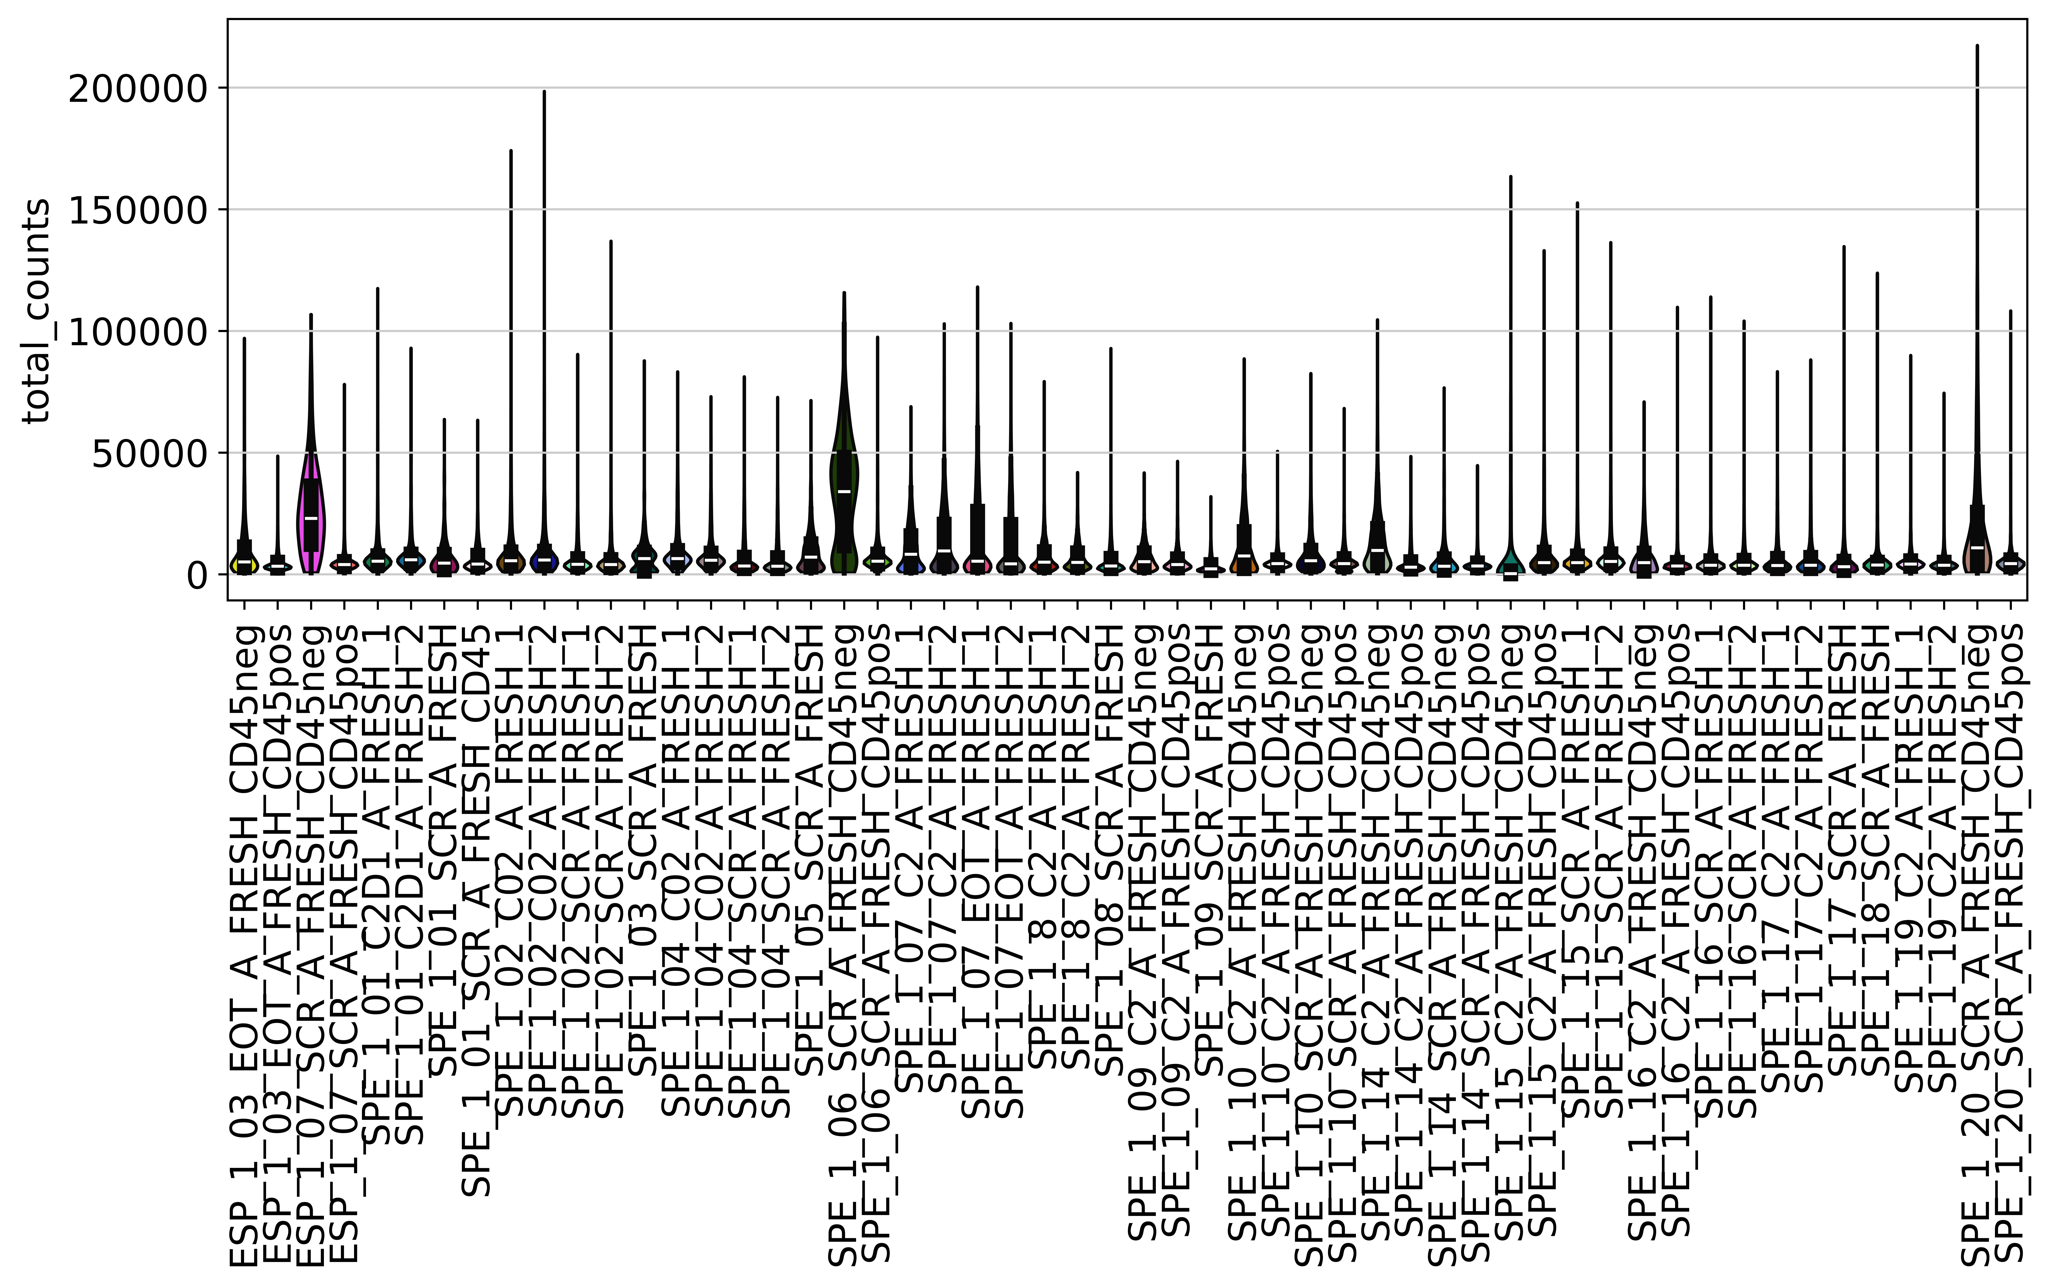

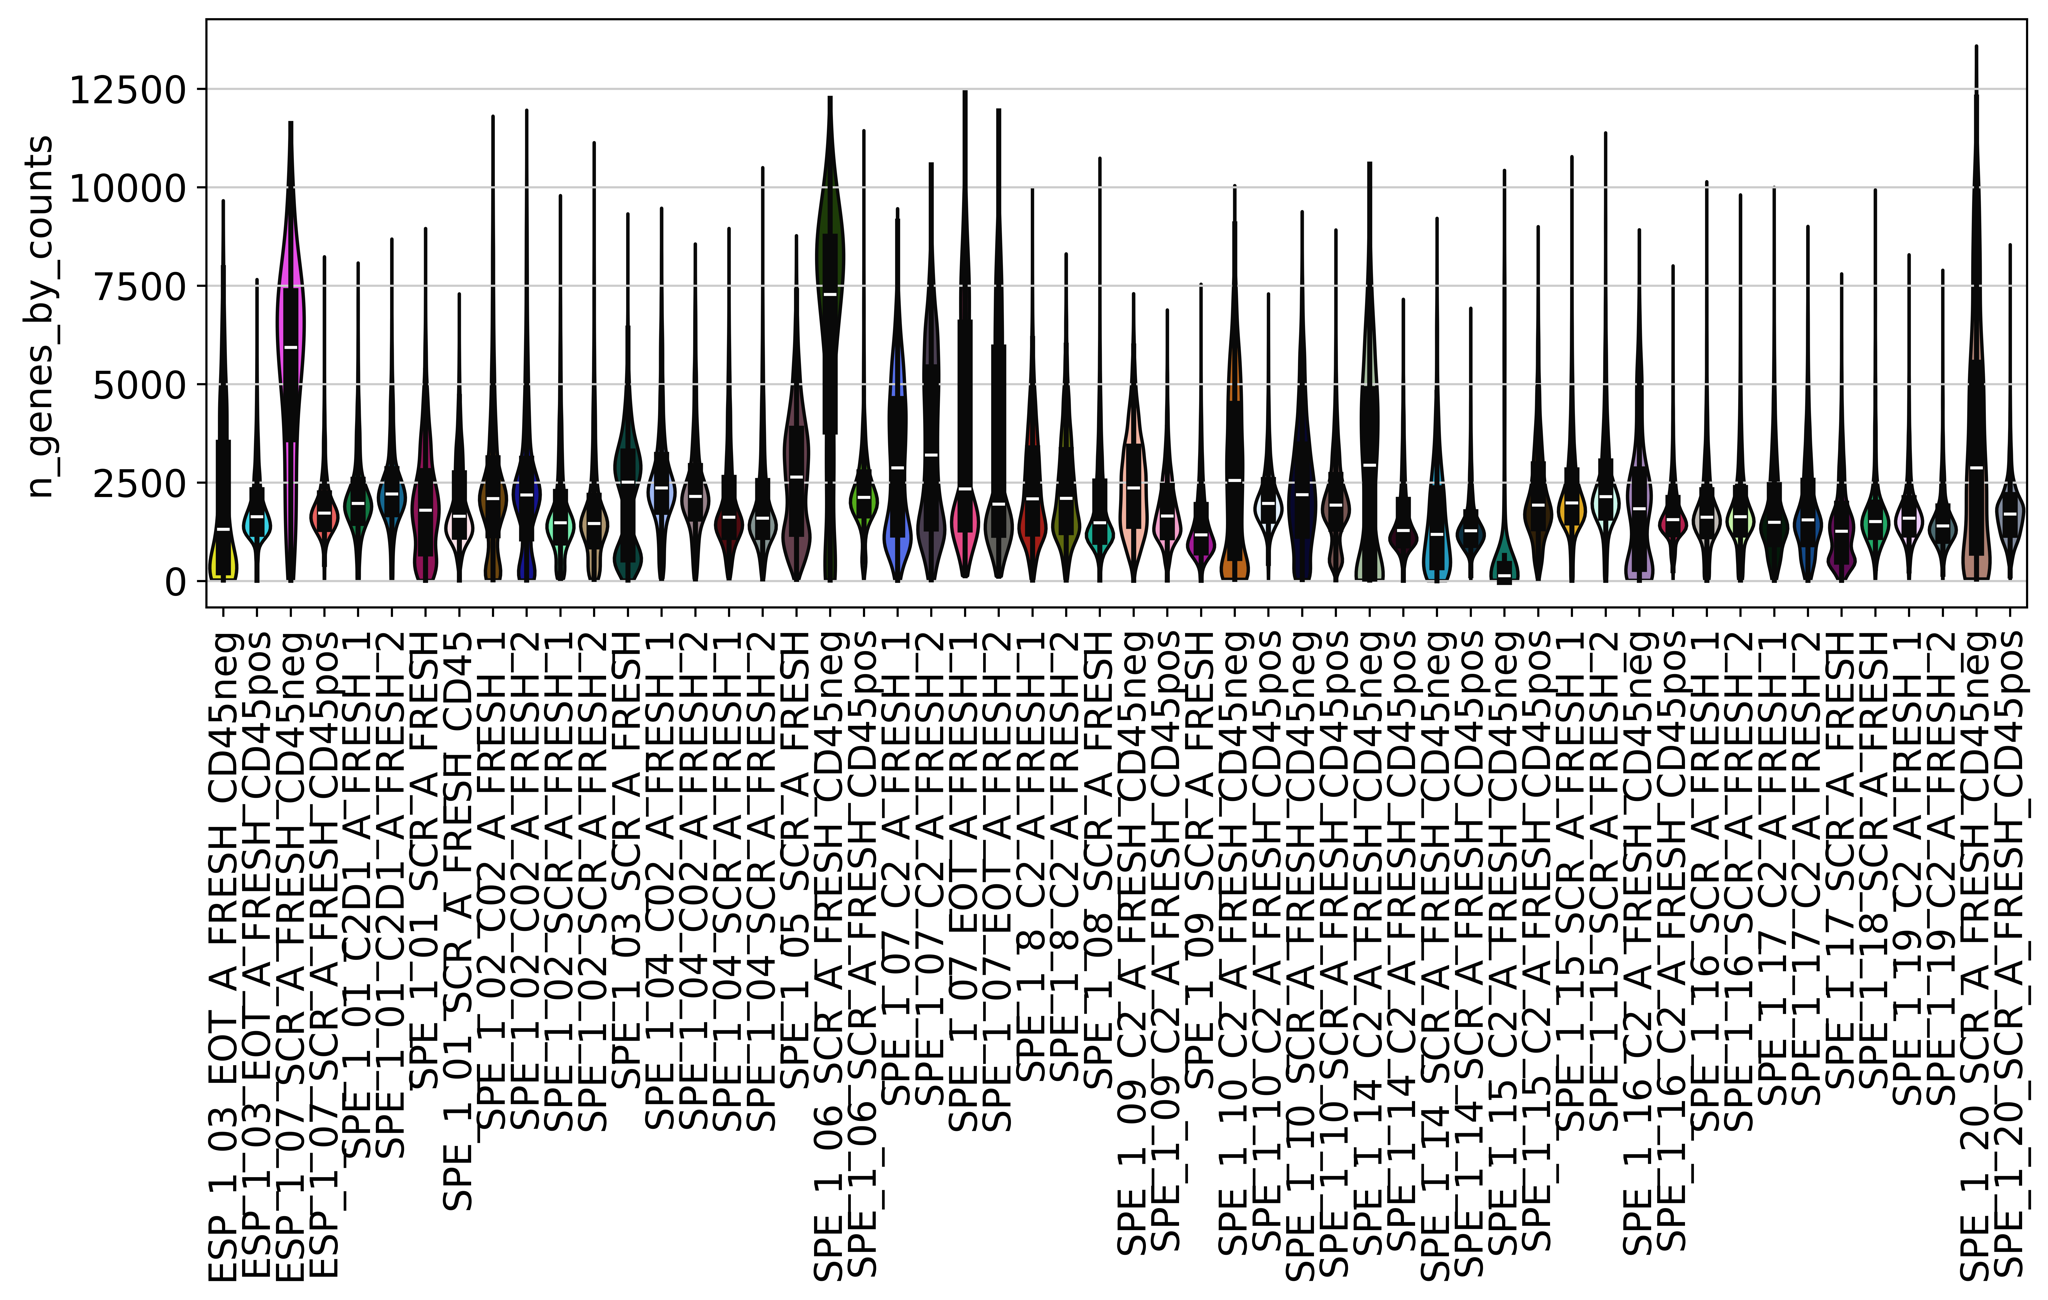

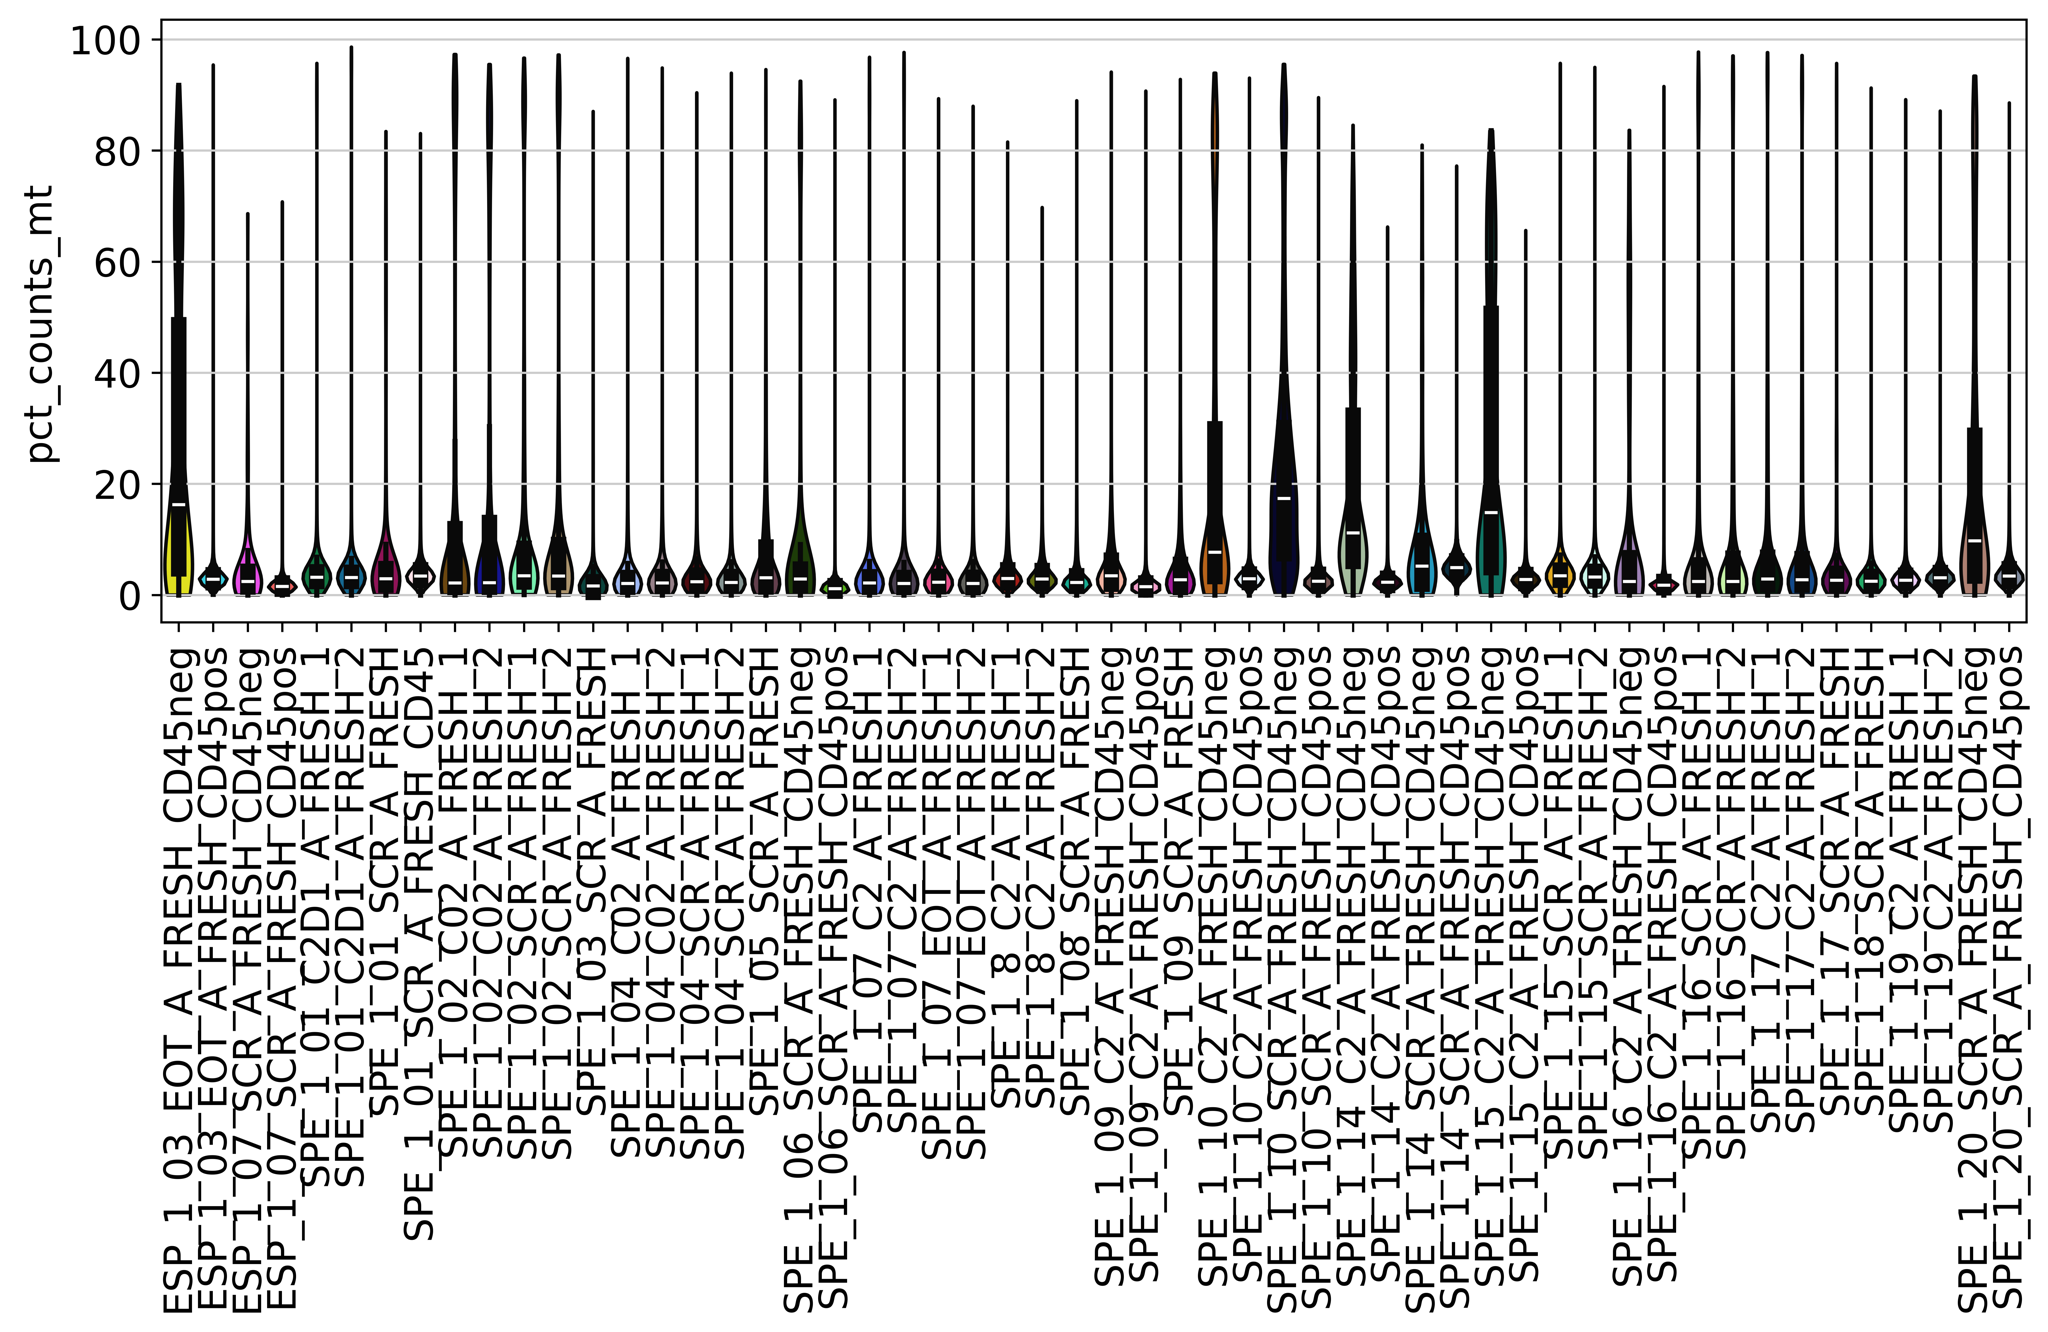

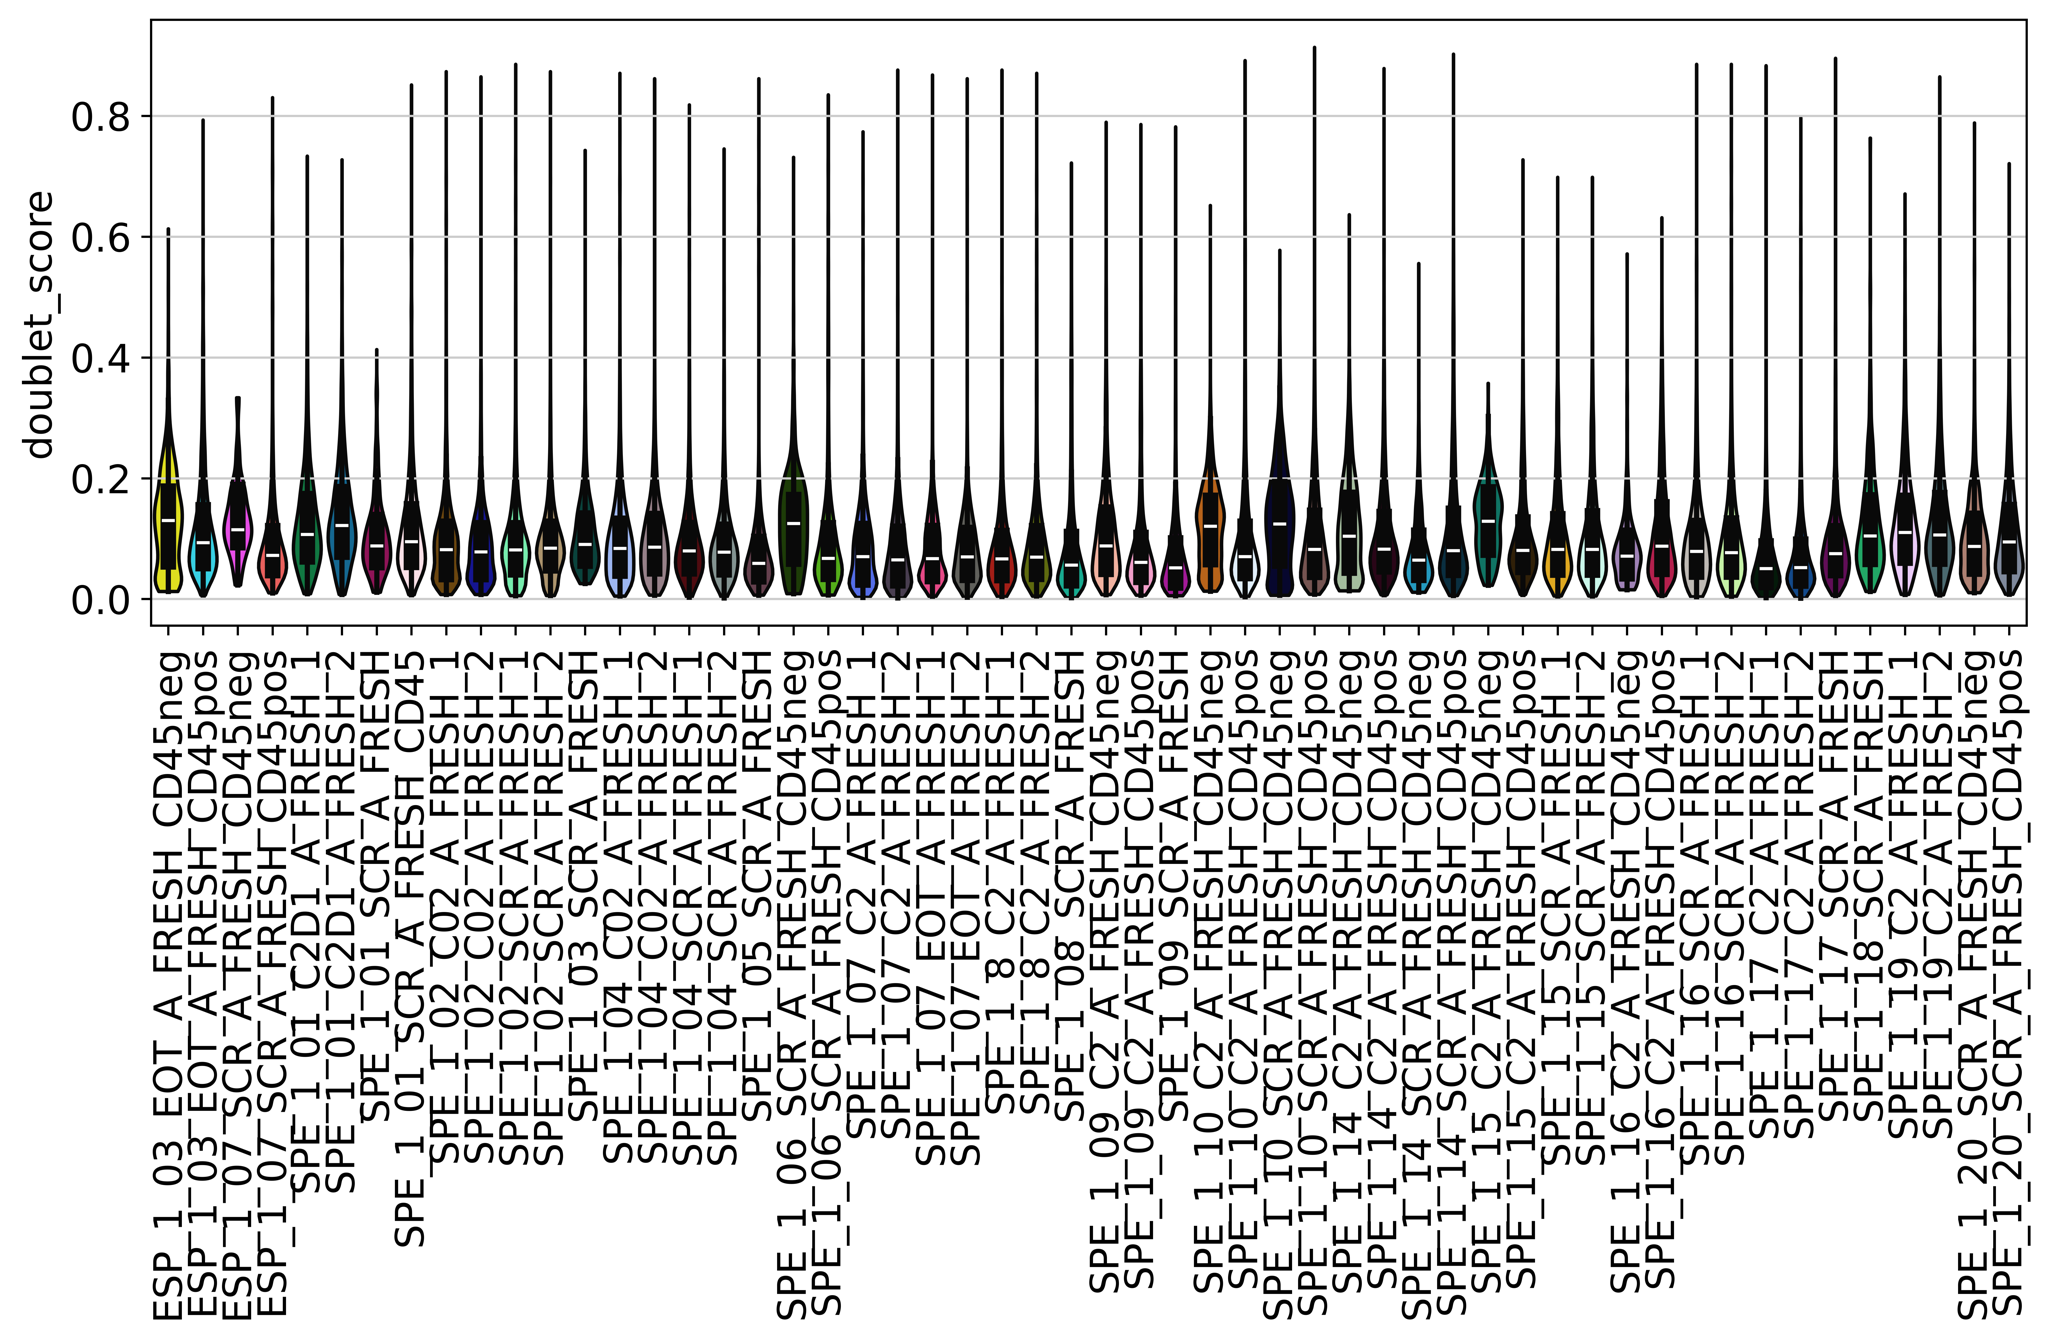

In [20]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,4), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='Replicate', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='Replicate', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='Replicate', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='Replicate', multi_panel=False, rotation=90)

## save the unprocessed dataset

In [21]:
adata.obs.head()

Subproject_CNAG             Replicate     Patient  \
barcode                                                                    
AAACCTGAGGAACTGC-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAACCTGGTCAAAGAT-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAAGATGAGTACGACG-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAAGATGCAGACGCAA-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAATGCCTCATCATTC-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   

                                    bc batch      DOB Tumor_Type  \
barcode                                                            
AAACCTGAGGAACTGC-1-0  AAACCTGAGGAACTGC     0  15APR71        CRC   
AAACCTGGTCAAAGAT-1-0  AAACCTGGTCAAAGAT     0  15APR71        CRC   
AAAGATGAGTACGACG-1-0  AAAGATGAGTACGACG     0  15APR71        CRC   
AAAGATGCAGACGCAA-1-0  AAAGATGCAGACGCAA     0  15APR71        CRC   
AAATGCCTCATCATTC-1-0  AAATGCCTCATCATTC     0  15APR71        CRC   

                     Primary_tumor       Histology Microsatellite_status  ...  \
barcode                                                                   ...   
AAACCTGAGGAACTGC-1-0        Rectum  Adenocarcinoma                   MSS  ...   
AAACCTGGTCAAAGAT-1-0        Rectum  Adenocarcinoma                   MSS  ...   
AAAGATGAGTACGACG-1-0        Rectum  Adenocarcinoma                   MSS  ...   
AAAGATGCAGACGCAA-1-0        Rectum  Adenocarcinoma                   MSS  ...   
AAATGCCTCATCATTC-1-0        Rectum  Adenocarcinoma                   MSS  ...   

                            Best_response     Tissue Timepoint Sample  \
barcode                                                                 
AAACCTGAGGAACTGC-1-0  Progression disease  Liver met         1      1   
AAACCTGGTCAAAGAT-1-0  Progression disease  Liver met         1      1   
AAAGATGAGTACGACG-1-0  Progression disease  Liver met         1      1   
AAAGATGCAGACGCAA-1-0  Progression disease  Liver met         1      1   
AAATGCCTCATCATTC-1-0  Progression disease  Liver met         1      1   

                     doublet_score predicted_doublet n_genes_by_counts  \
barcode                                                                  
AAACCTGAGGAACTGC-1-0      0.066282             False              2572   
AAACCTGGTCAAAGAT-1-0      0.106870             False              4203   
AAAGATGAGTACGACG-1-0      0.072727             False              1862   
AAAGATGCAGACGCAA-1-0      0.013289             False                24   
AAATGCCTCATCATTC-1-0      0.164948             False              2137   

                     total_counts total_counts_mt pct_counts_mt  
barcode                                                          
AAACCTGAGGAACTGC-1-0       6301.0           213.0      3.380416  
AAACCTGGTCAAAGAT-1-0      14171.0           342.0      2.413379  
AAAGATGAGTACGACG-1-0       5350.0           160.0      2.990654  
AAAGATGCAGACGCAA-1-0        939.0           664.0     70.713524  
AAATGCCTCATCATTC-1-0       3885.0            45.0      1.158301  

[5 rows x 30 columns]

In [22]:
adata.write('{}SERPENTINE_merged_unprocessed_211124.h5ad'.format(data_dir))

## First-pass PCA-based clustering analysis

In [147]:
adata = sc.read_h5ad('{}SERPENTINE_merged_unprocessed_111124.h5ad'.format(data_dir))

In [ ]:
# load the unprocessed dataset
adata = sc.read('{}SERPENTINE_merged_unprocessed_111124.h5ad'.format(data_dir))

# save the counts layer
adata.layers['counts'] = adata.X 

In [78]:
# normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# retain the "Raw" adata object for later
adata.raw = adata

In [79]:
# identify HVGs
sc.pp.highly_variable_genes(adata)

In [80]:
# scale HVGs + run PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [81]:
# neighbors
sc.pp.neighbors(
    adata, use_rep = 'X_pca', 
    n_neighbors=20, n_pcs=30, metric='cosine'
)

In [82]:
# clustering 
sc.tl.leiden(adata, resolution=1)
sc.tl.dendrogram(adata, 'leiden')

IOStream.flush timed out
IOStream.flush timed out


In [ ]:
sc.tl.umap(adata, min_dist=0.35, method='umap')

In [200]:
# save the results
adata.write('{}SERPENTINE_PCA_111124.h5ad'.format(data_dir))

In [183]:
# re-load
adata = sc.read_h5ad('{}SERPENTINE_PCA_111124.h5ad'.format(data_dir))

## Plotting clusters

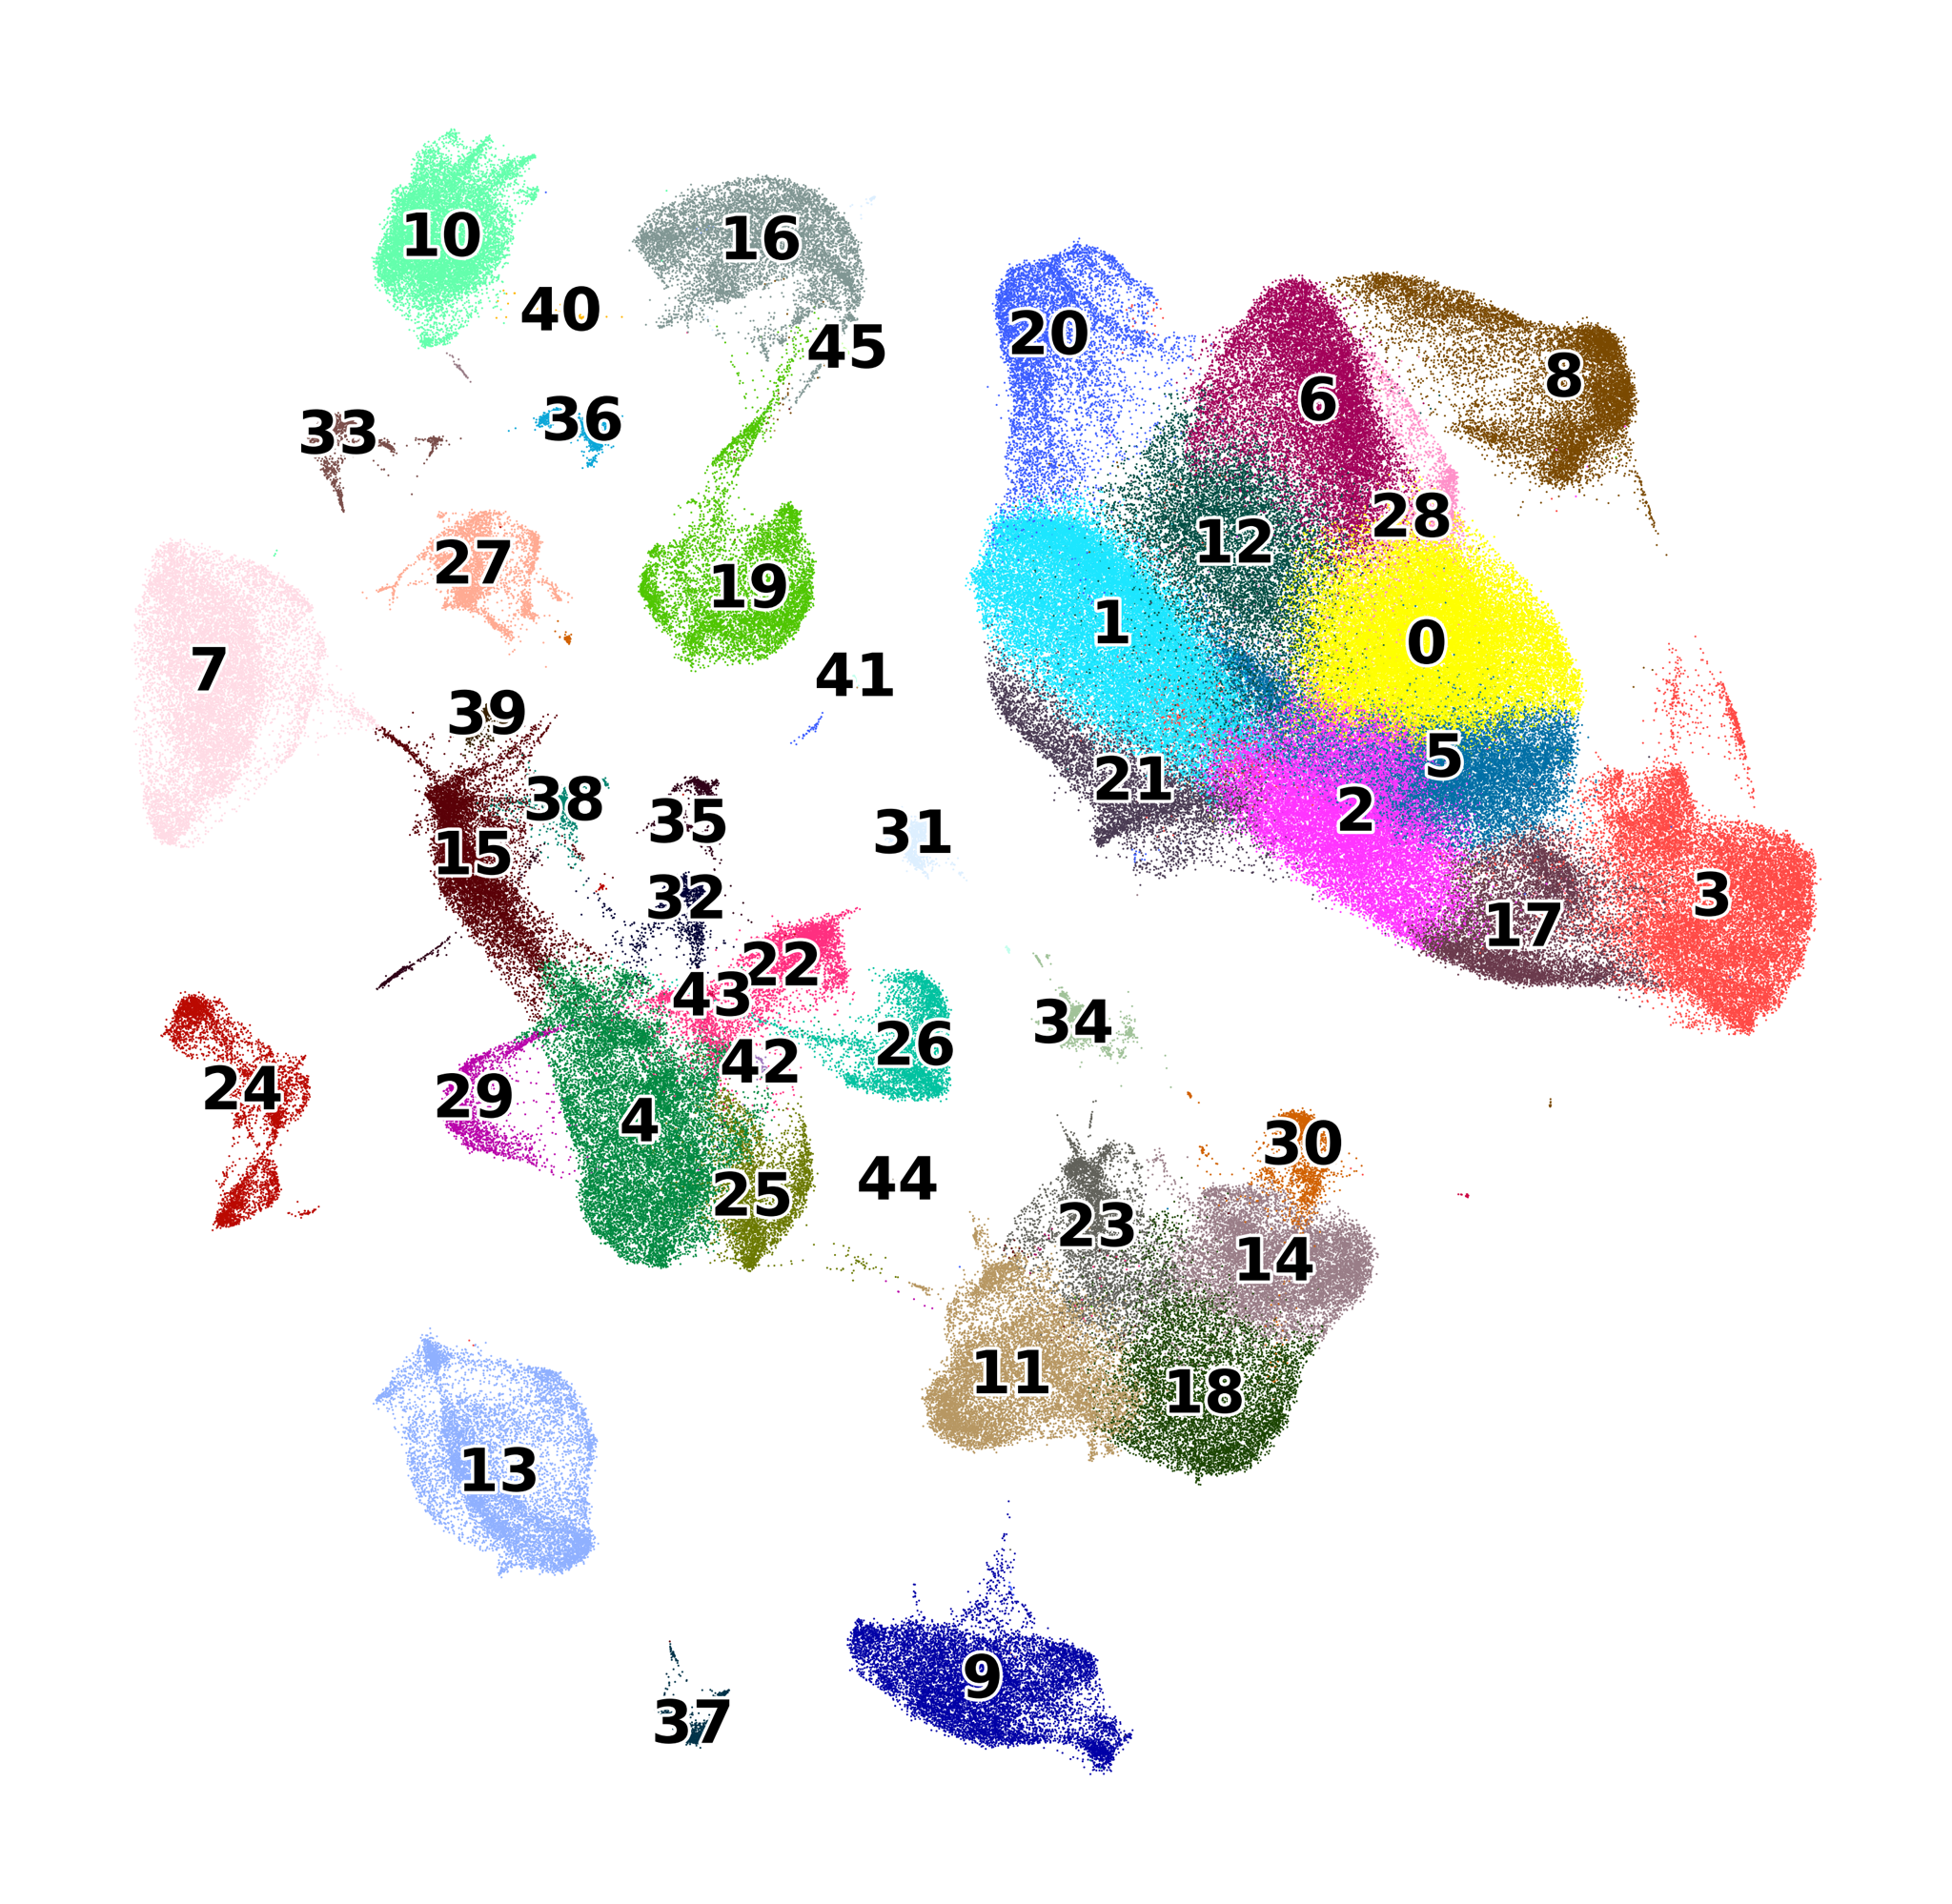

In [85]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['leiden'],
    frameon=False, 
    legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    title='',
    save='_leiden.pdf'
)

In [92]:
adata.obs.columns

Index(['Subproject_CNAG', 'Replicate', 'Patient', 'bc', 'batch', 'DOB',
       'Tumor_Type', 'Primary_tumor', 'Histology', 'Microsatellite_status',
       'Molecular_profile', 'N_pre_lines', 'Previous_therapies',
       'Metastases_location', 'Cohort', 'Treatment', 'Biopsy_pre-treat',
       'Biopsy_pre-C2', 'Biopsy', 'BiopsyEOT', 'Best_response',
       'doublet_score', 'predicted_doublet', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'],
      dtype='object')

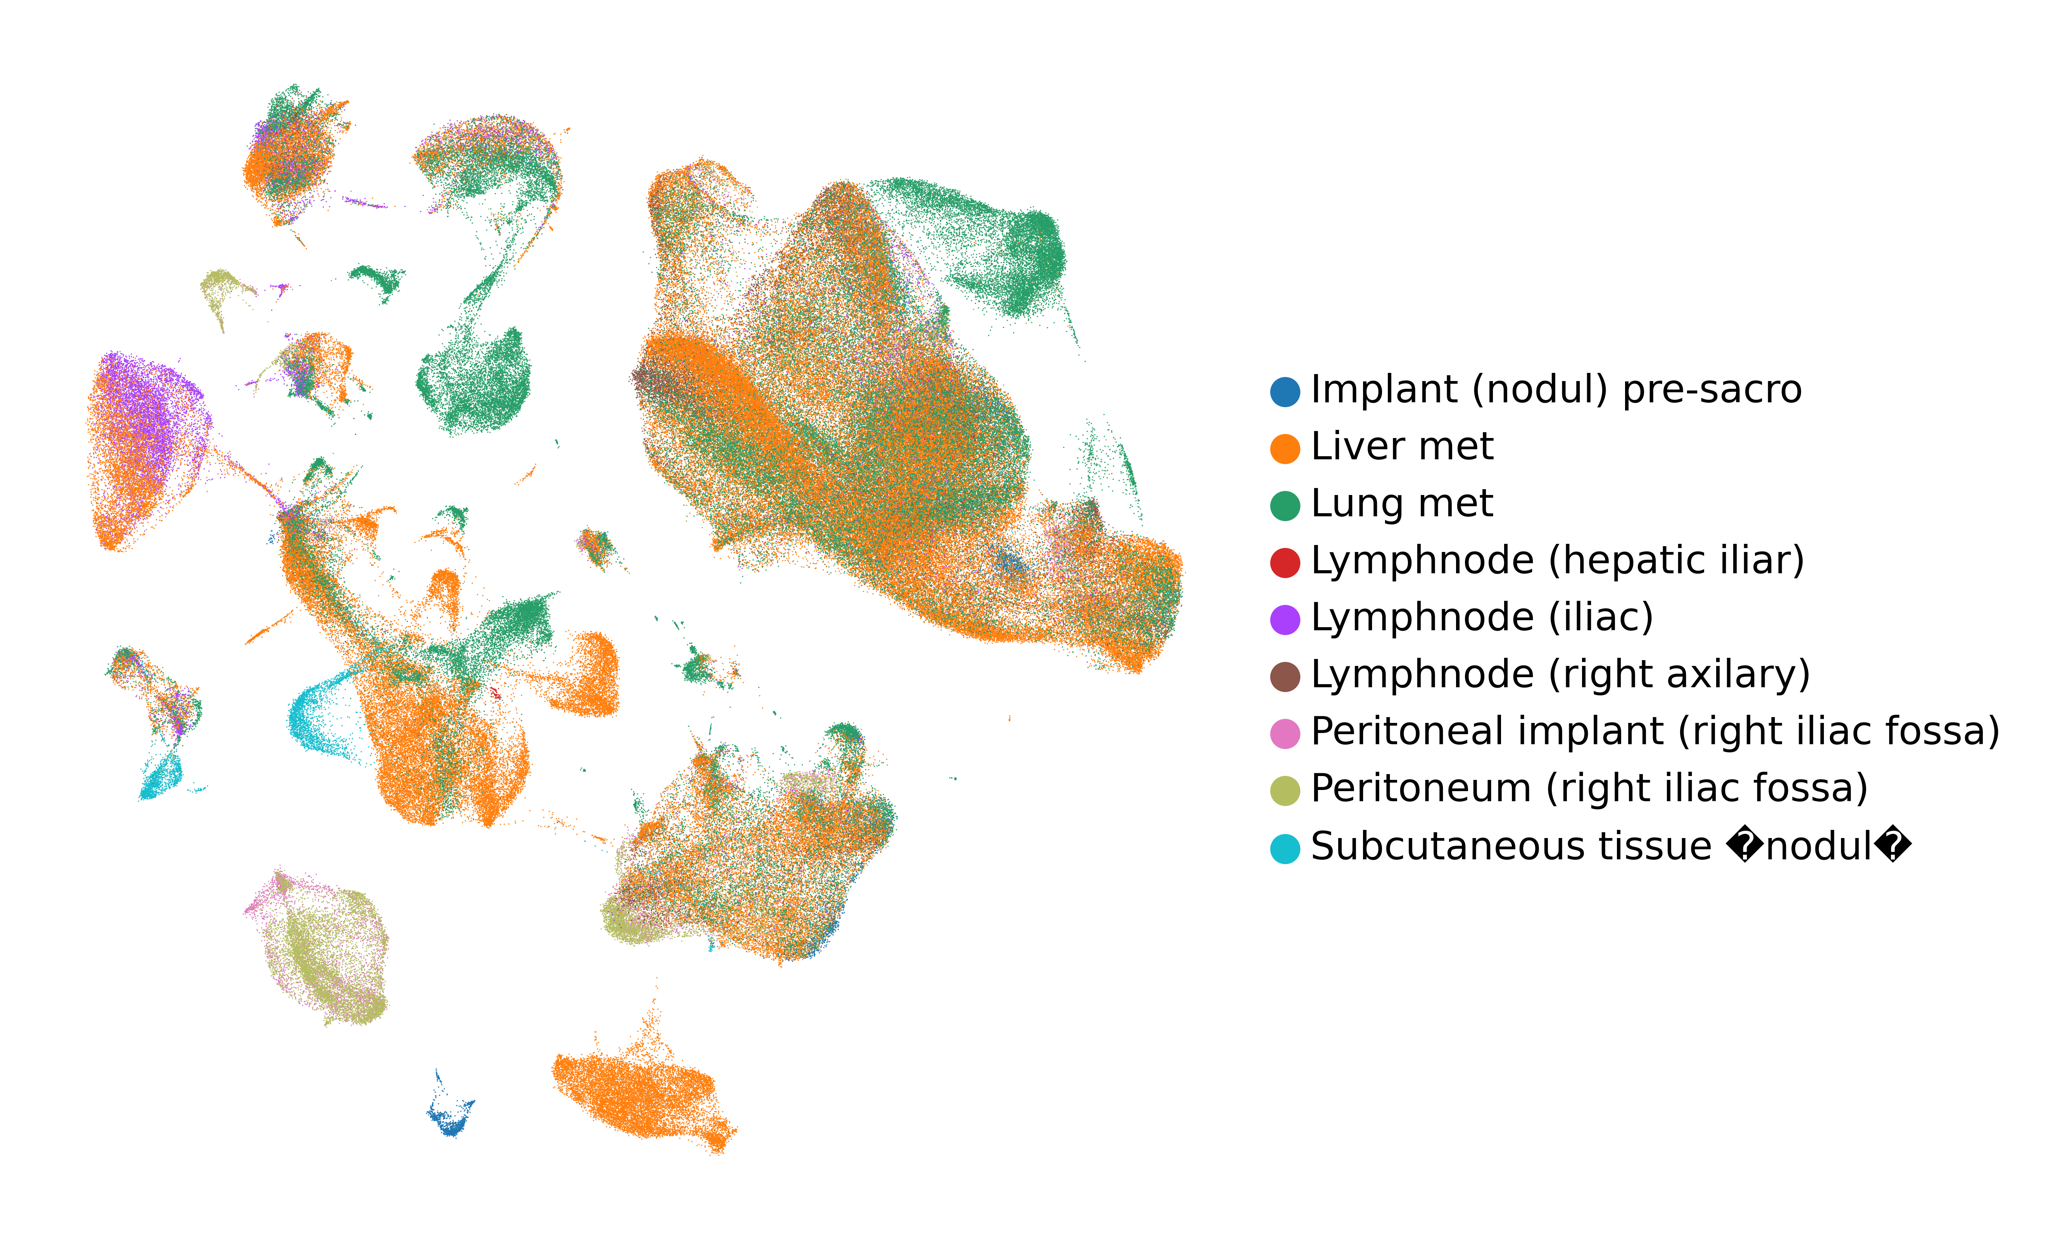

In [199]:
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(5,5), facecolor='white')
sc.pl.umap(
    adata, 
    color=['Tissue'],
    frameon=False, 
    #legend_loc='on data', 
    legend_fontoutline=1, 
    legend_fontsize=9, 
    title='',
    save='_tissue.pdf'
)

In [102]:
adata.obs.head()

Subproject_CNAG             Replicate     Patient  \
barcode                                                                    
AAACCTGAGGAACTGC-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAACCTGGTCAAAGAT-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAAGATGAGTACGACG-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAAGATGCAGACGCAA-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   
AAATGCCTCATCATTC-1-0  SERPENTINE_04_05  SPE_1_01_SCR_A_FRESH  Patient 01   

                                    bc batch      DOB Tumor_Type  \
barcode                                                            
AAACCTGAGGAACTGC-1-0  AAACCTGAGGAACTGC     0  15APR71        CRC   
AAACCTGGTCAAAGAT-1-0  AAACCTGGTCAAAGAT     0  15APR71        CRC   
AAAGATGAGTACGACG-1-0  AAAGATGAGTACGACG     0  15APR71        CRC   
AAAGATGCAGACGCAA-1-0  AAAGATGCAGACGCAA     0  15APR71        CRC   
AAATGCCTCATCATTC-1-0  AAATGCCTCATCATTC     0  15APR71        CRC   

                     Primary_tumor       Histology Microsatellite_status  ...  \
barcode                                                                   ...   
AAACCTGAGGAACTGC-1-0        Rectum  Adenocarcinoma                   MSS  ...   
AAACCTGGTCAAAGAT-1-0        Rectum  Adenocarcinoma                   MSS  ...   
AAAGATGAGTACGACG-1-0        Rectum  Adenocarcinoma                   MSS  ...   
AAAGATGCAGACGCAA-1-0        Rectum  Adenocarcinoma                   MSS  ...   
AAATGCCTCATCATTC-1-0        Rectum  Adenocarcinoma                   MSS  ...   

                     doublet_score predicted_doublet n_genes_by_counts  \
barcode                                                                  
AAACCTGAGGAACTGC-1-0      0.066282             False              2572   
AAACCTGGTCAAAGAT-1-0      0.106870             False              4203   
AAAGATGAGTACGACG-1-0      0.072727             False              1862   
AAAGATGCAGACGCAA-1-0      0.013289             False                24   
AAATGCCTCATCATTC-1-0      0.164948             False              2137   

                     total_counts total_counts_mt pct_counts_mt leiden Tissue  \
barcode                                                                         
AAACCTGAGGAACTGC-1-0       6301.0           213.0      3.380416      1    NaN   
AAACCTGGTCAAAGAT-1-0      14171.0           342.0      2.413379     11    NaN   
AAAGATGAGTACGACG-1-0       5350.0           160.0      2.990654      0    NaN   
AAAGATGCAGACGCAA-1-0        939.0           664.0     70.713524     15    NaN   
AAATGCCTCATCATTC-1-0       3885.0            45.0      1.158301     11    NaN   

                     Sample Timepoint  
barcode                                
AAACCTGAGGAACTGC-1-0    NaN       NaN  
AAACCTGGTCAAAGAT-1-0    NaN       NaN  
AAAGATGAGTACGACG-1-0    NaN       NaN  
AAAGATGCAGACGCAA-1-0    NaN       NaN  
AAATGCCTCATCATTC-1-0    NaN       NaN  

[5 rows x 31 columns]

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

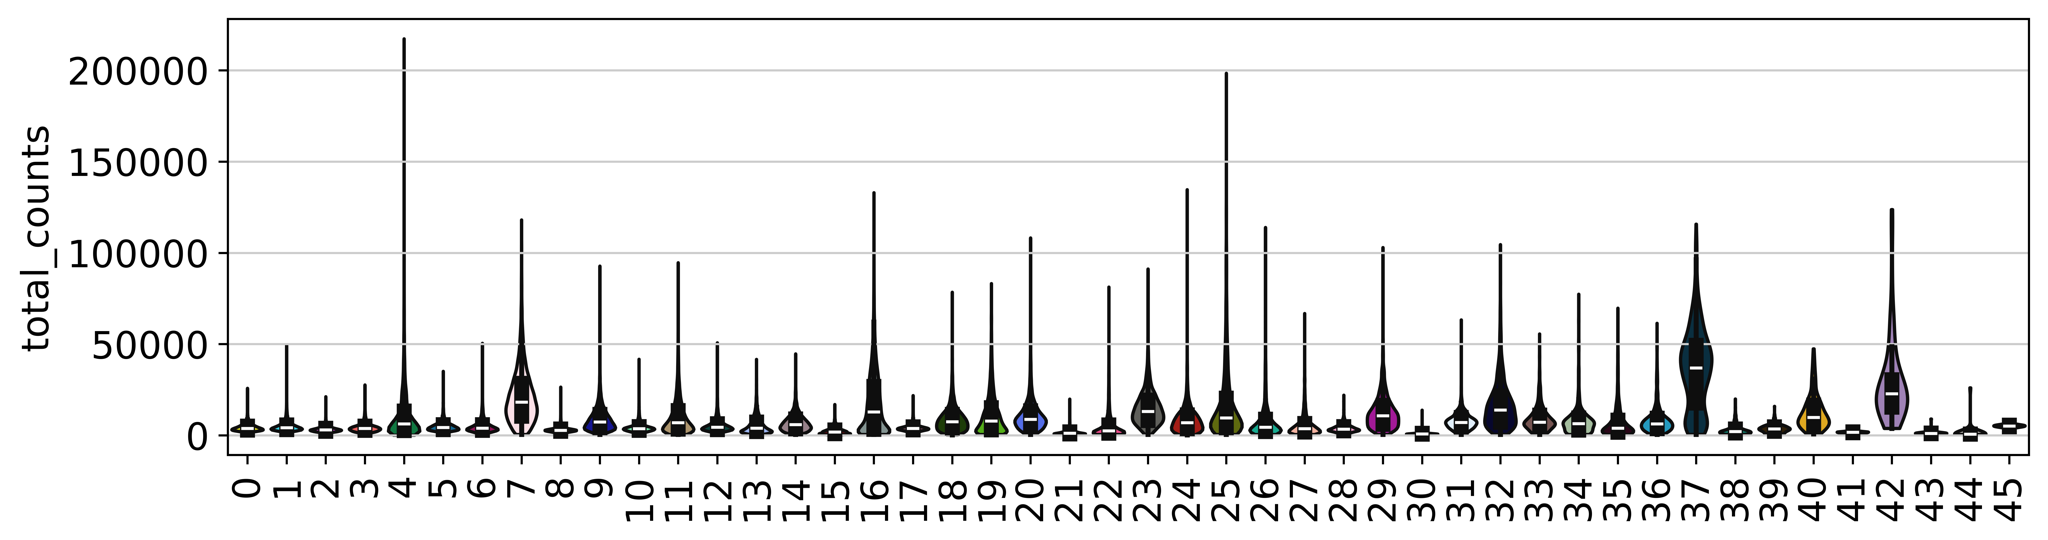

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

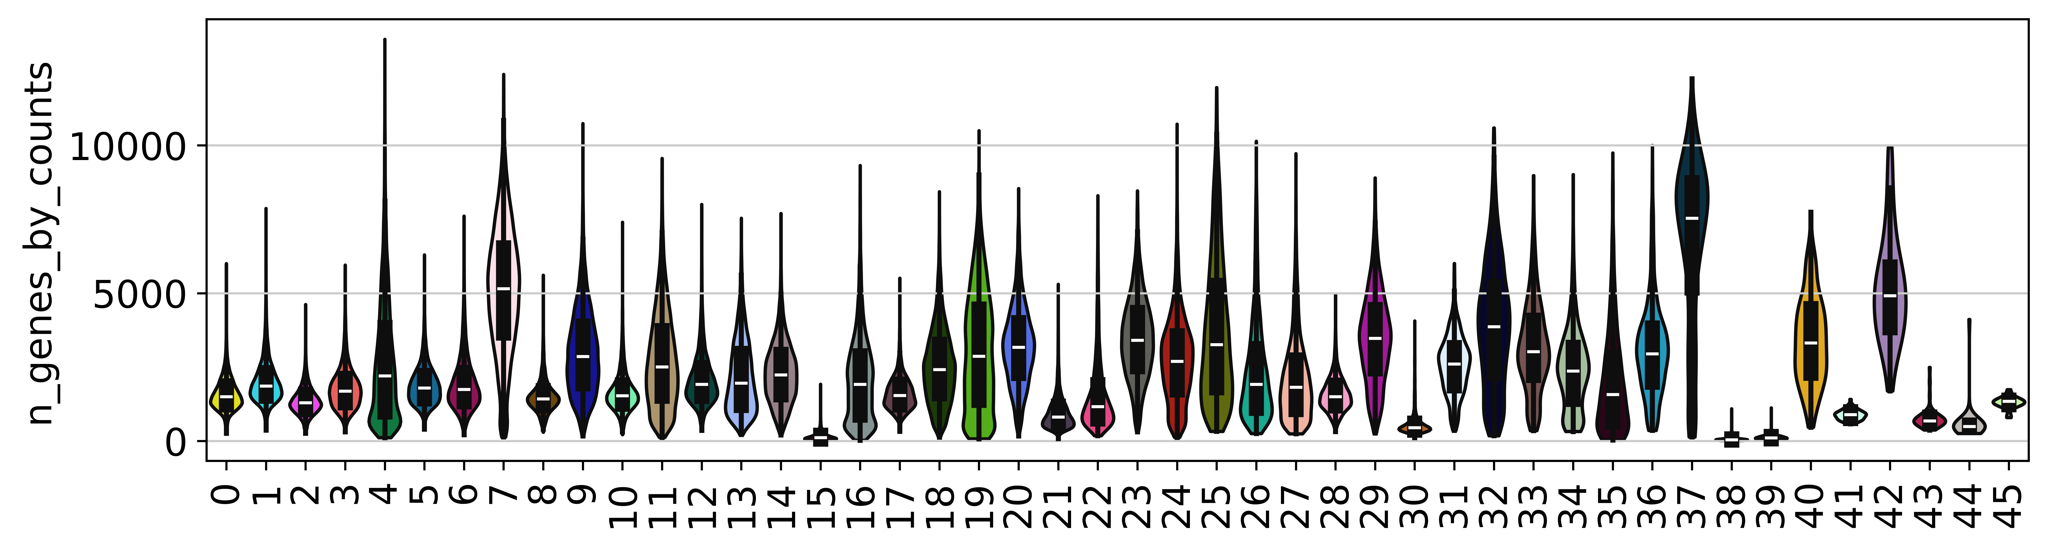

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

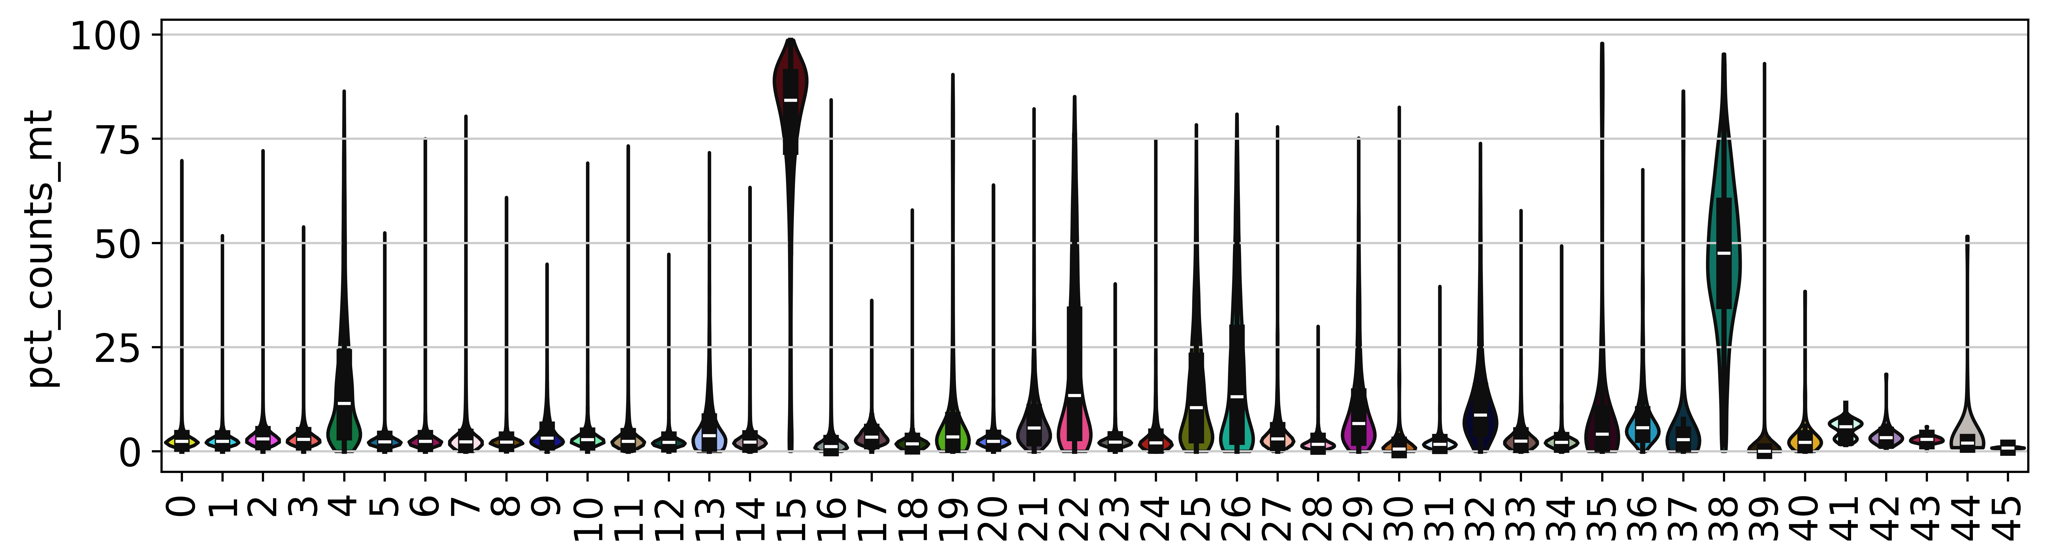

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

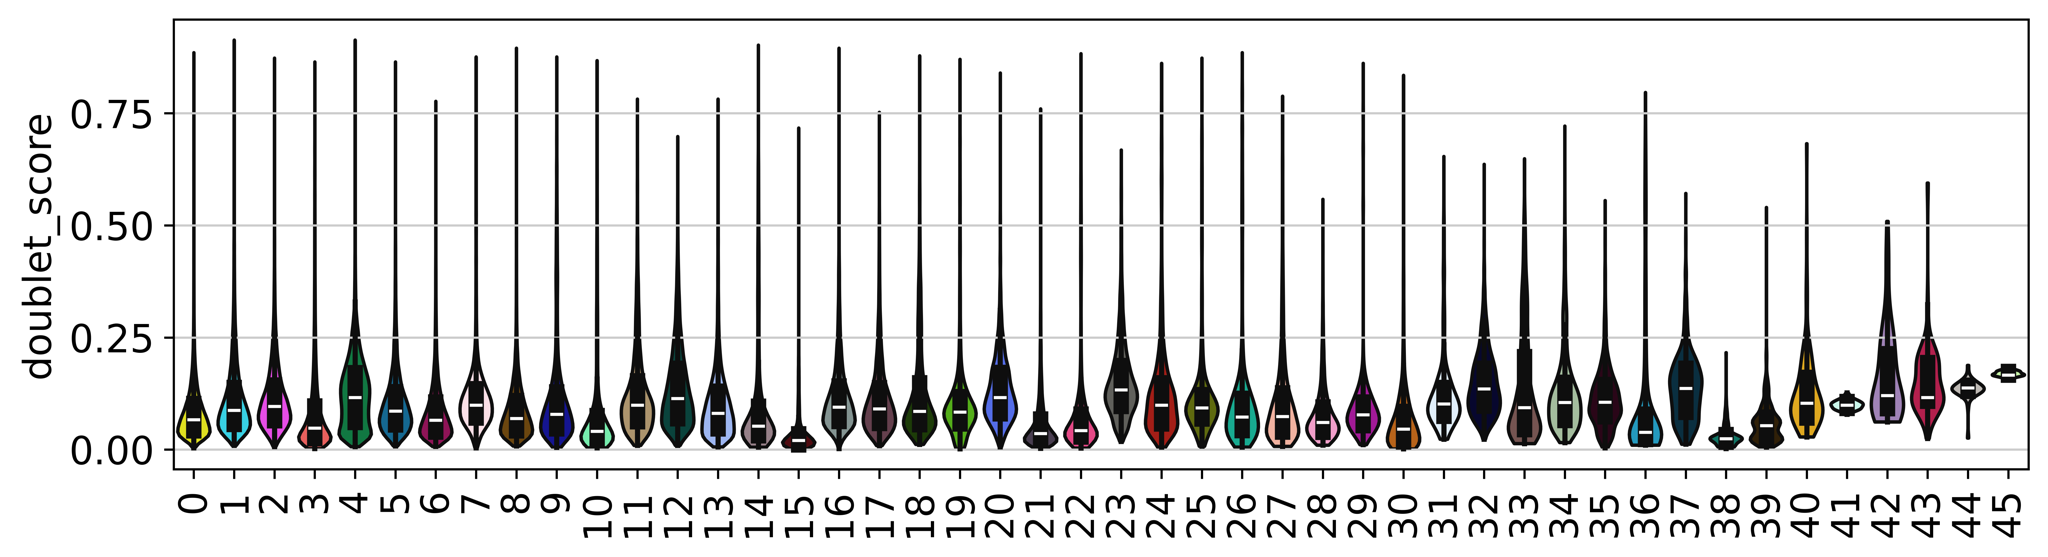

In [86]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,3), facecolor='white')
sc.pl.violin(adata,[ 'total_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'pct_counts_mt'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(adata,[ 'doublet_score'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)

categories: 0, 1, 2, etc.
var_group_labels: Immune, CD4 + T, CD8+ T, etc.


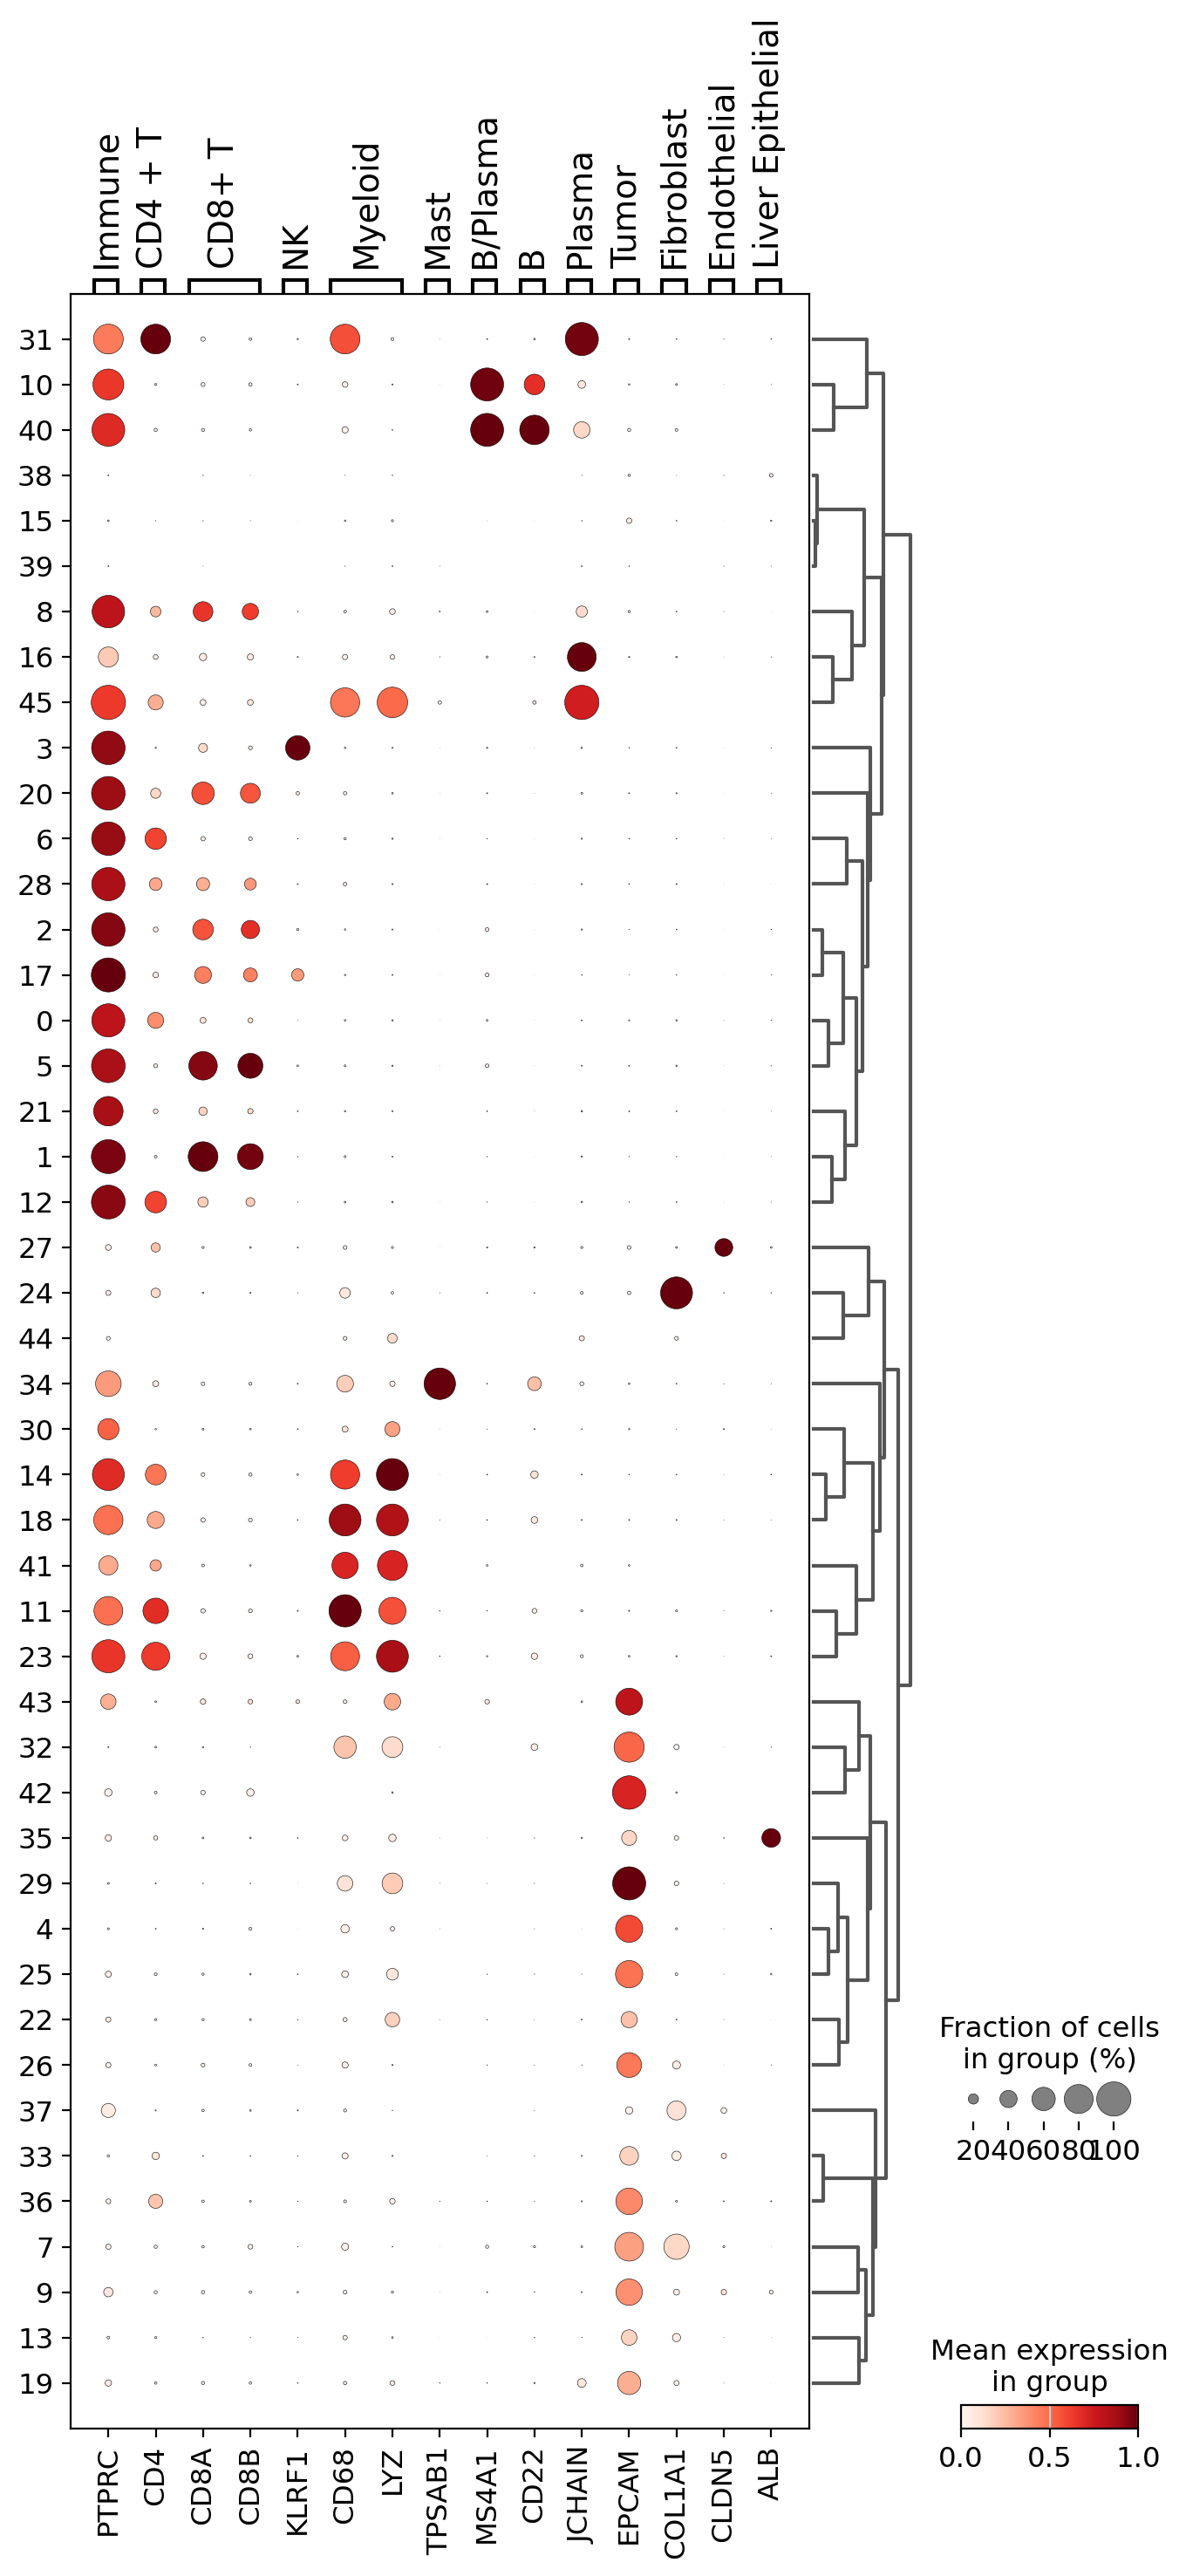

In [89]:

sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(15,5), facecolor='white')

marker_dict = {
    'Immune': ['PTPRC'],
    'CD4 + T': ['CD4'],
    'CD8+ T': ['CD8A', 'CD8B'],
    'NK': ['KLRF1'],
    'Myeloid': ['CD68', 'LYZ'],
    'Mast': ['TPSAB1'],
    'B/Plasma': ['MS4A1'],
    'B': ['CD22'],
    'Plasma': ['JCHAIN'],
    'Tumor': ['EPCAM'],
    'Fibroblast': ['COL1A1'],
    'Endothelial': ['CLDN5'],
    'Liver Epithelial': ['ALB']
}



sc.pl.dotplot(
    adata, marker_dict, 'leiden',
    dendrogram=True,
    standard_scale='var', swap_axes=False,
    save = '_leiden_markers_primary.pdf'
)

#sc.pl.dotplot(adata, marker_dict, groupby='leiden', figsize=(12,6), standard_scale='var',  dendrogram=True, save='markers.pdf')

In [202]:
adata.obs.leiden.value_counts()

leiden
0     32098
1     27456
2     22103
3     20481
4     15524
5     15285
6     15240
7     13450
8     11760
9     11621
10    11592
11    10898
12    10700
13    10142
14     9903
15     9388
16     8865
17     8729
18     8320
19     7982
20     7214
21     7041
22     5112
23     4803
24     4567
25     4068
26     4041
27     3838
28     3046
29     2279
30     2252
31     1515
32     1424
33     1372
34     1304
35     1188
36     1165
37      965
38      894
39      756
40      144
41       61
42       61
43       58
44       38
45       21
Name: count, dtype: int64

In [203]:
12/35

0.34285714285714286